# Theory of SEIR Model

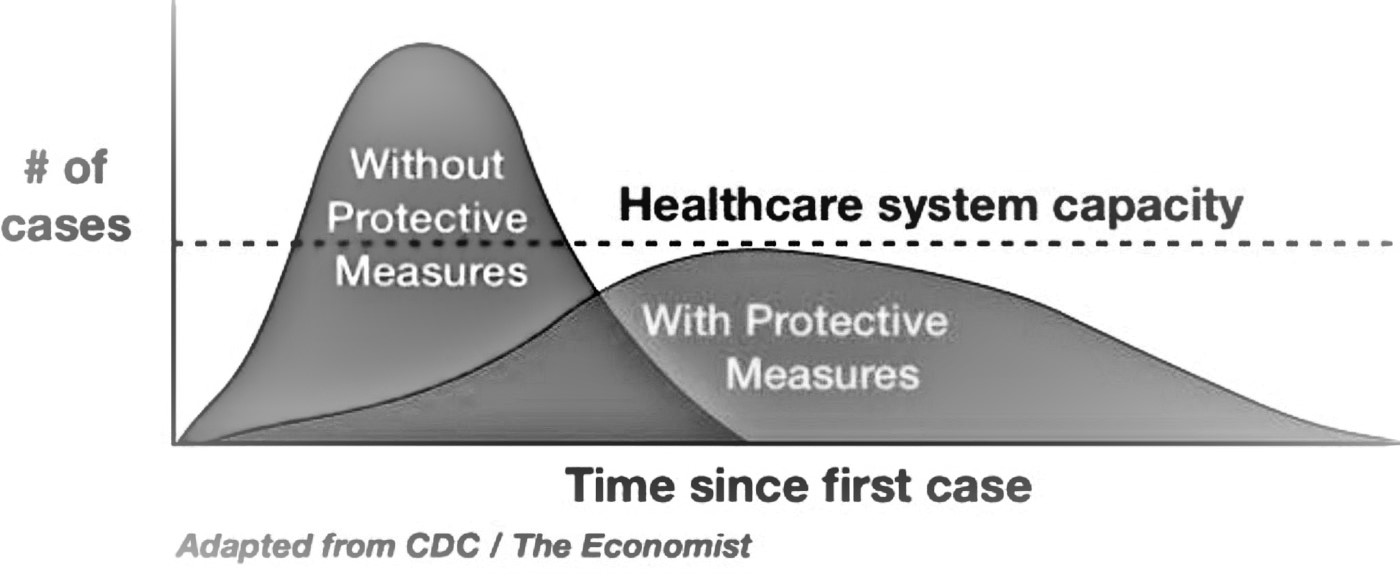

In [3]:
from IPython.display import Image
Image(path_dir+"input\\SEIR_Theory2.png")

The idea is to reduce person-to-person contact in order to make spreading the disease less likely. The effects of this are often illustrated in images above, where the left plot is flattened to spread out the disease as much as possible. This helps to ensure that there are sufficient resources available for a sick population, which will help improve survival rates.

In [4]:
# N = 1000000  # Population size
# n_infected = 1
# max_days = 200
# initial_state = [(N - n_infected)/ N, 0, n_infected / N, 0]

# R_0 = 2.7 # Reproductive Number
# t_inc = 5.6 # Incubation Period
# t_inf = 2.9 # Recovery Period

# args = (R_0, t_inc, t_inf)
# sol11 = solve_ivp(seir_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

# def time_varying_reproduction1(t):
#     if t > intervention_day:
#         return R_t
#     else:
#         return R_0
    
# intervention_day = 80
# R_t = 0.7

# args = (time_varying_reproduction1, t_inc, t_inf)
# sol12 = solve_ivp(seir_model, [0, max_days], initial_state, args=args, t_eval=np.arange(max_days))

# # Plot General SEIR model Result

# sns.set(style="darkgrid")
# fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,5))
# ax1.set_title(' SEIR Model Without Intervention')
# ax2.set_title(' SEIR Model With Intervention')

# sus, exp, inf, rec = sol11.y
# ax1.plot(sus, 'b', label='Susceptible');
# ax1.plot(exp, 'y', label='Exposed');
# ax1.plot(inf, 'r', label='Infected');
# ax1.plot(rec, 'c', label='Recovered/deceased');
# ax1.set_xlabel("Days", fontsize=10);
# ax1.set_ylabel("Fraction of population", fontsize=10);
# ax1.legend(loc='best')

# sus, exp, inf, rec = sol12.y
# ax2.plot(sus, 'b', label='Susceptible');
# ax2.plot(exp, 'y', label='Exposed');
# ax2.plot(inf, 'r', label='Infected');
# ax2.plot(rec, 'c', label='Recovered/deceased');
# ax2.set_xlabel("Days", fontsize=10);
# ax2.set_ylabel("Fraction of population", fontsize=10);
# ax2.legend(loc='best')

# Reading & Data Prepration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os
from tqdm.notebook import tqdm
from scipy.integrate import solve_ivp
import scipy.stats as st
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from scipy.optimize import curve_fit, fsolve, minimize
import time
from datetime import datetime, timedelta
from scipy import integrate, optimize
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
path_dir = 'C:\\Users\\kumapank\\Documents\\COVID-19\\'

In [5]:
col_nm = ['Province/State','Country/Region','Lat','Long','Date','Value']
conf_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_confirmed_global_narrow.csv')
conf_df = conf_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Confirmed'})
dth_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_deaths_global_narrow.csv')
dth_df = dth_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Death'})
rcv_df = pd.read_csv(path_dir+'\\input\\time_series_2019 Vertical Data\\time_series_covid19_recovered_global_narrow.csv')
rcv_df = rcv_df[col_nm].drop(index=0).rename(index=str,columns={'Value':'Recovered'})
conf_df.Date = pd.to_datetime(conf_df.Date, format='%Y-%m-%d')
dth_df.Date = pd.to_datetime(dth_df.Date, format='%Y-%m-%d')
rcv_df.Date = pd.to_datetime(rcv_df.Date, format='%Y-%m-%d')

In [6]:
df = pd.merge(conf_df,dth_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death']
df = pd.merge(df,rcv_df,left_on=['Province/State','Country/Region','Lat','Long','Date'],right_on=['Province/State','Country/Region','Lat','Long','Date'],how='left')
df.columns = ['Province/State','Country/Region','Lat','Long','Date','Confirmed','Death','Recovered']
df = df.sort_values(by=['Province/State','Country/Region','Date'], ascending=(True,True,True))
df.Confirmed = df.Confirmed.fillna(0)
df.Death = df.Death.fillna(0)
df.Recovered = df.Recovered.fillna(0)
df.Confirmed = df.Confirmed.astype(int)
df.Death = df.Death.astype(int)
df.Recovered = df.Recovered.astype(int)
df= df.groupby(by=['Country/Region','Date'])['Confirmed','Death','Recovered'].sum().reset_index()
df.head()

,Country/Region,Date,Confirmed,Death,Recovered
0,Afghanistan,2020-01-22,0,0,0
1,Afghanistan,2020-01-23,0,0,0
2,Afghanistan,2020-01-24,0,0,0
3,Afghanistan,2020-01-25,0,0,0
4,Afghanistan,2020-01-26,0,0,0


## Data Cleaning

In [7]:
Date_threshold = '2020-04-04' # Cutoff date to validate the results

In [8]:
# Creating population disctionary lookup table
# Load the population data into lookup dicts
pop_info = pd.read_csv(path_dir+ 'input\\population_data.csv')
country_pop = pop_info.query('Type == "Country/Region"')
province_pop = pop_info.query('Type == "Province/State"')
country_lookup = dict(zip(country_pop['Name'], country_pop['Population']))
province_lookup = dict(zip(province_pop['Name'], province_pop['Population']))

# cummax function to remove some data cumulation anomalies 
df['Confirmed'] = df.groupby('Country/Region')['Confirmed'].cummax()
df['Death'] = df.groupby('Country/Region')['Death'].cummax()
df['Recovered'] = df.groupby('Country/Region')['Recovered'].cummax()

df['Removed'] = df.Death + df.Recovered
df['ActiveInfected'] = df.Confirmed - df.Removed
req_col = ['ActiveInfected','Removed']

# Multi-index 
df.set_index(['Country/Region', 'Date'], inplace=True)
df = df[req_col]
df.shape

(16465, 2)

In [9]:
# data = df.loc['India'].query('ActiveInfected > 0')
# data[data.index<= Date_threshold]

# Train SIR Model for COVID19

## Important Functions

 Below function is the basic SEIR equation. R_t is the time varying paramter. It will change based on the intevention applied on a specific day. This equation is solved using initial value probelm (solv_ivp).

In [10]:
# SEIR Model Equation
def sir_model(t,initial_val, R_0, T_inf):
    
    if callable(R_0):
        R_t = R_0(t)
    else:
        R_t = R_0
    
#     alpha = 1/T_inc # rate of expose
    gamma = 1/T_inf # rate of recovery
    beta = R_t*gamma # rate of infection
    
    S, I, R= initial_val 
    
    dSdt = -(beta * S * I) 
#     dEdt = (beta * S * I) - (alpha * E)
    dIdt = (beta * S * I) - (gamma * I)
    dRdt = gamma * I
    
    return dSdt, dIdt, dRdt;

Below function will run over different boundry value of R0, Incubation and Infection period. At the same time it will calculate the mean square log error between actual and predected value. We have stored all the calculated parameter in a dataframe and later we saved it in a csv file in (). It save lot of time. 

In [11]:
# find the best estimate for beta and gamma
def sir_param_estimate(params, data,population):
    a,c,k = params
    N = population*k
    n_infected = data['ActiveInfected'].values[0]
    max_days = len(data)

    initial_state = [(N - n_infected)/ N, n_infected / N, 0]
    args1 = [a,c]
    sol1 = solve_ivp(sir_model, [0, max_days], initial_state, args=args1, t_eval=np.arange(max_days))
    optim_days = min(28, max_days)  # Days to optimise for manually days
    weights = 1 / np.arange(1, optim_days+1)[::-1]  # Recent data is more heavily weighted

    pred_infected = sol1.y[1]*N
    pred_infected = np.clip(pred_infected,0,np.inf)
    act_infected = data['ActiveInfected'].values
    MSLE_infected = mean_squared_log_error(pred_infected[-optim_days:,],act_infected[-optim_days:,],weights)
    pred_removed = sol1.y[2]*N
    pred_removed = np.clip(pred_removed,0,np.inf)
    act_removed = data['Removed'].values
    MSLE_removed = mean_squared_log_error(pred_removed[-optim_days:,],act_removed[-optim_days:,],weights)
    MSLE = np.mean([MSLE_infected,MSLE_removed])
    return MSLE;

In [15]:
#Plot SEIR Model Results
def plot_results(country,pred_df,intervention_param,best_estimate_param,
                 Obs_start = '2020-03-01',Obs_end = '2020-05-01'):
#     if all_pic:
#         if intervention_param[0] == None:
#             intervention = pd.to_datetime(min(pred_df.index))
#         else:
#             intervention = pd.to_datetime(intervention_param[0])
#         pred_df['without_intr_SUS'].loc[pred_df.without_intr_SUS >=max(pred_df.without_itr_INF)*2] = None
#         pred_df['with_intr_SUS'].loc[pred_df.with_intr_SUS >=max(pred_df.without_itr_INF)*2] = None
#         sns.set(style="whitegrid")
#         fig, ax1 = plt.subplots(1, figsize=(12,6))
#         ax1.set_title(country + ' SEIR Model Projection')
#         pred_df.loc[pred_df.index,'ActiveInfected'].plot(label='Training Actual Infection', color='r', ax=ax1)
#         ax1.axvline(x=min(pred_df[pred_df.index> Date_threshold].index),color='black',linestyle = '--', 
#                     label='Training Boundary')
#         pred_df.loc[pred_df.index,'without_itr_INF'].plot(label='No Interven Pred Infection', color='b', ax=ax1)
#         ax1.plot(intervention,0,'^',label='Intervention Day') 
# #         pred_df.loc[pred_df.index,'without_intr_SUS'].plot(label='No Interven Susceptible', color='g', ax=ax1)
#         pred_df.loc[pred_df.index,'with_intr_INF'].plot(label='With Interven Pred Infection', color='b',linestyle=':', ax=ax1)
# #         pred_df.loc[pred_df.index,'with_intr_SUS'].plot(label='With Interven Susceptible', color='c', ax=ax1)
#         pred_df.loc[pred_df.index,'with_intr_EXP'].plot(label='With Interven Exposed', color='y', ax=ax1)
#         ax1.set_ylabel("Population")
#         ax1.legend(loc='best')

#     else:
    if intervention_param[0] == None:
        intervention = pd.to_datetime(min(pred_df.index))
    else:
        intervention = pd.to_datetime(intervention_param[0])
    temp = pred_df[(pred_df.index >= Obs_start) & (pred_df.index <= Obs_end)]
    sns.set(style="whitegrid")
    fig, ax2 = plt.subplots(1, figsize=(12,6))
    ax2.set_title(country + ' SIR Model Projection')
    temp.loc[temp.index,'ActiveInfected'].plot(label='Training Actual Infection', color='r', ax=ax2)
    temp.loc[temp.index,'Removed'].plot(label='Training Actual Removed', color='g', ax=ax2)
    ax2.axvline(x=min(temp[temp.index> Date_threshold].index),color='black',linestyle = '--', label='Training Boundary')
    temp.loc[temp.index,'without_itr_INF'].plot(label='Infected Prediction Without Inter', color='b', ax=ax2)
    ax2.plot(intervention,0,'^',label='Intervention Day') 
    temp.loc[temp.index,'without_itr_RMV'].plot(label='Removed Prediction Without Inter', color='y', ax=ax2)
    temp.loc[temp.index,'with_intr_INF'].plot(label='Infected Prediction With Inter', color='b',linestyle=':', ax=ax2)
    temp.loc[temp.index,'with_intr_RMV'].plot(label='Removed Prediction With Inter', color='y',linestyle=':', ax=ax2)
    ax2.set_ylabel("Population")
    ax2.legend(loc='best')
    del(temp)
    return print("Estimated Parameter: R0 %5.2f, | Training Mean Square Log Error: %5.3f " 
                 %(best_estimate_param[0],best_estimate_param[3]))


The best estimated parameter calculated using two functions "seir_param_estimate" & "extract_train_param". Once we have the best parameter we predict the SEIR result for S, E, I, & R. this is the final predicted value for a given country.

In [12]:
#Predict Covid 19 Incidence
def predict_covid_instance(best_estimate_param,data,population,intervention_param,decay_L=70,decay_k=6,max_days = 200):    

    train = data[data.index<= Date_threshold]
    st_dt = pd.to_datetime(min(train.index),format='%Y-%m-%d')
    dates_all = np.array([ st_dt + timedelta(days=x) for x in range(0,max_days)])

    active_infected = train['ActiveInfected'].values
    N = population*best_estimate_param[2]
    
    n_infected = active_infected[0]
    initial_state = [(N - n_infected)/ N, n_infected / N, 0]
    
    
    if intervention_param[0] == None:
        without_intr_sol = solve_ivp(sir_model, [0, max_days], initial_state, args=best_estimate_param[:-2], 
                             t_eval=np.arange(max_days))
        without_intr_sol = without_intr_sol.y
        with_intr_sol = without_intr_sol
        
    else:        
        without_intr_sol = solve_ivp(sir_model, [0, max_days], initial_state, args=best_estimate_param[:-2], 
                                     t_eval=np.arange(max_days))
        without_intr_sol = without_intr_sol.y
        
        intervention_day = (pd.to_datetime(intervention_param[0],format='%Y-%m-%d')- st_dt).days
        
        def time_varying_reproduction(t):
            if t > intervention_day:
                return best_estimate_param[0]/(1 + (t/decay_L)**decay_k)
            else:
                return best_estimate_param[0]

        argms = [time_varying_reproduction,best_estimate_param[1]] 
        with_intr_sol = solve_ivp(sir_model, [0, max_days], initial_state, args=argms, t_eval=np.arange(max_days))
        with_intr_sol = with_intr_sol.y

    pred_df = pd.DataFrame({'without_intr_SUS': np.clip(without_intr_sol[0]*N,0,np.inf),
                          'without_itr_INF': np.clip(without_intr_sol[1]*N,0,np.inf),
                          'without_itr_RMV': np.clip(without_intr_sol[2]*N,0,np.inf),
                          'with_intr_RMV': np.clip(with_intr_sol[2]*N,0,np.inf),
                          'with_intr_INF': np.clip(with_intr_sol[1]*N,0,np.inf)},index=dates_all)
    pred_df=pred_df.join(data)
    return pred_df

## Train SIR Parameters & Display Results

Dynamic way to save the estimated parameters value. The below function will run "seir_param_estimate" function and save the result in CSV file if we have retrained the equation

In [13]:
def display_output(area_name,intervention_param,obs_start,obs_end,cutoff=1,decay_L=70,decay_k=6):
    
    try:
        population = country_lookup[area_name]
    except KeyError:
        population = province_lookup[area_name]

    data = df.loc[area_name]
    data = data[data['ActiveInfected']>cutoff]
#     n_infected = data['ActiveInfected'].values[0]

    res_const = minimize(sir_param_estimate, [2.0,2,0.025], bounds=((1, 70),(1, 800),(0.0001,0.02)),
                         args=(data, population), method='L-BFGS-B')
    best_estimate_param = list(res_const.x) + [res_const.fun]  

    pred_df = predict_covid_instance(best_estimate_param,data,population,intervention_param,decay_L=decay_L,decay_k=decay_k)
    forecast_df = pred_df.loc[pred_df.index> max(data.index)].without_itr_INF.values
    plot_results(area_name ,pred_df,intervention_param,best_estimate_param,obs_start,obs_end)
    
    if intervention_param[0] == None:        
        Max_infected_people = int(max(pred_df.without_itr_INF))
        st = pred_df[pred_df.without_itr_INF==max(pred_df.without_itr_INF)].index        
        print('Apex Day Without Intervention:', st[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',
              Max_infected_people)
        print('Forecasted Value: ',[int(x) for x in forecast_df[0:8]])
    else:
        Max_infected_people = int(max(pred_df.without_itr_INF))
        st = pred_df[pred_df.without_itr_INF==max(pred_df.without_itr_INF)].index 
        
        Max_infected_people1 = int(max(pred_df.with_intr_INF))
        st1 = pred_df[pred_df.with_intr_INF==max(pred_df.with_intr_INF)].index 
        print('Apex Day Without Intervention:', st[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',
              Max_infected_people)
        print('Apex Day With Intervention:', st1[0].strftime("%b %d %Y"),'| Maximum Active Infected Population:',
              Max_infected_people1)
        print('Forecasted Value: ',[int(x) for x in forecast_df[0:8]])

    return best_estimate_param, pred_df;

## Model Prediction

### US Projection

Estimated Parameter: R0 21.99, | Training Mean Square Log Error: 0.017 
Apex Day Without Intervention: Apr 19 2020 | Maximum Active Infected Population: 613274
Apex Day With Intervention: Apr 20 2020 | Maximum Active Infected Population: 600017
Forecasted Value:  [612450, 610541, 607755, 604254, 600179, 595658, 590797, 585669]


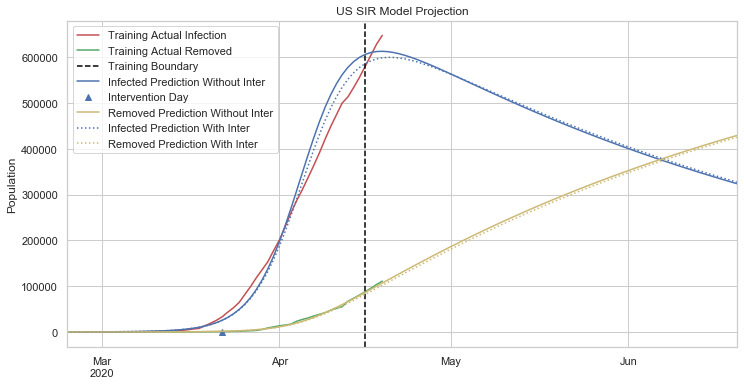

In [16]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-03-22'] # [None]# day and the R0 value; None if no intervention
obs_start = '2020-02-07'
obs_end = '2020-06-20'

param, out_df = display_output('US',intervention_param,obs_start,obs_end,cutoff=20,decay_L=80,decay_k=4) 

### Spain Projection

Estimated Parameter: R0  8.28, | Training Mean Square Log Error: 0.026 
Apex Day Without Intervention: Apr 05 2020 | Maximum Active Infected Population: 115972
Apex Day With Intervention: Apr 08 2020 | Maximum Active Infected Population: 103400
Forecasted Value:  [78331, 75460, 72670, 69963, 67340, 64801, 62346, 59975]


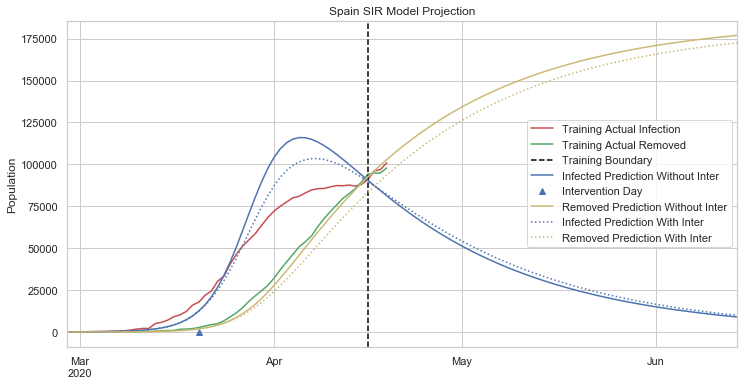

In [17]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-03-20'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-02-07'
obs_end = '2020-06-14'

param, out_df = display_output('Spain',intervention_param,obs_start,obs_end,cutoff=20,decay_L=50,decay_k=3) 

### Italy Projection

Estimated Parameter: R0  9.94, | Training Mean Square Log Error: 0.017 
Apex Day Without Intervention: Apr 06 2020 | Maximum Active Infected Population: 113827
Apex Day With Intervention: Apr 09 2020 | Maximum Active Infected Population: 100406
Forecasted Value:  [93031, 91069, 89120, 87188, 85276, 83388, 81526, 79693]


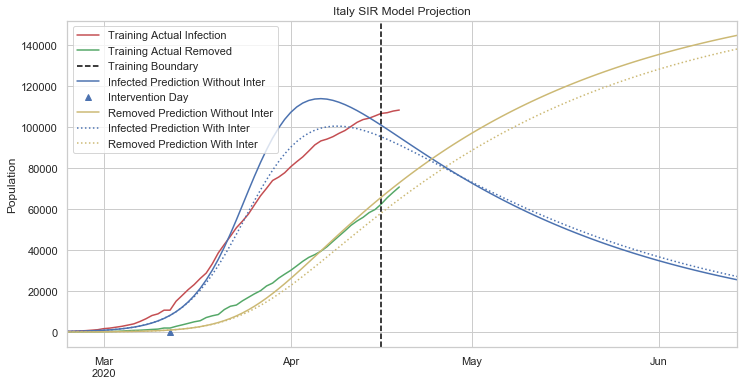

In [18]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-03-12'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-02-07'
obs_end = '2020-06-14'

param, out_df = display_output('Italy',intervention_param,obs_start,obs_end,cutoff=150,decay_L=50,decay_k=3) 

### India Projection

Estimated Parameter: R0  6.79, | Training Mean Square Log Error: 0.025 
Apex Day Without Intervention: May 15 2020 | Maximum Active Infected Population: 78794
Apex Day With Intervention: May 14 2020 | Maximum Active Infected Population: 40651
Forecasted Value:  [19106, 21460, 24009, 26750, 29686, 32798, 36051, 39408]


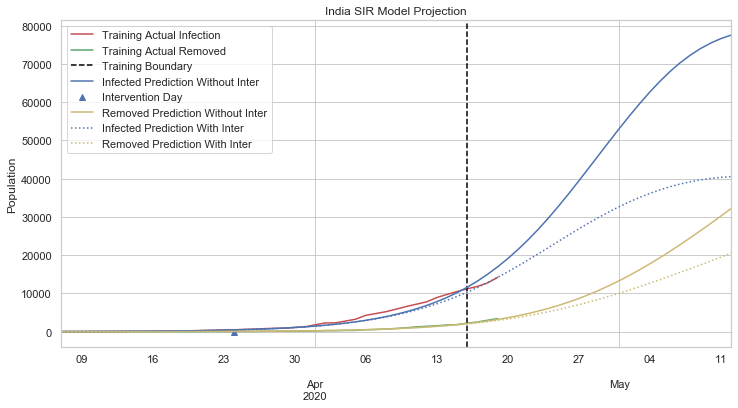

In [19]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-03-24'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-03-07'
obs_end = '2020-05-12'

param, out_df = display_output('India',intervention_param,obs_start,obs_end,cutoff=10,decay_L=60,decay_k=6) 

### Iran Projection

Estimated Parameter: R0  3.88, | Training Mean Square Log Error: 0.012 
Apex Day Without Intervention: Apr 04 2020 | Maximum Active Infected Population: 32935
Apex Day With Intervention: Apr 04 2020 | Maximum Active Infected Population: 31325
Forecasted Value:  [17143, 16112, 15128, 14190, 13295, 12448, 11647, 10892]


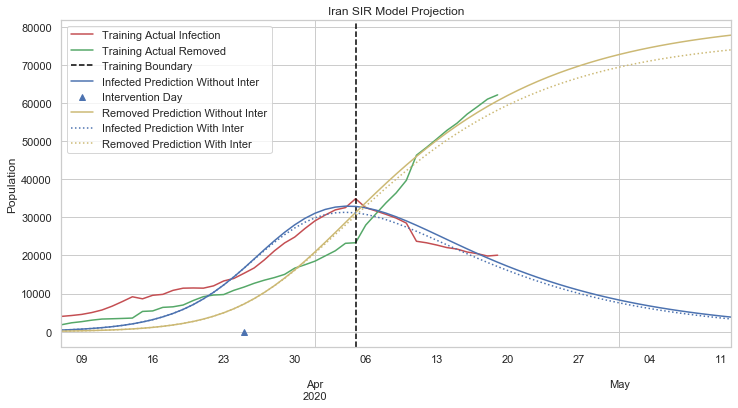

In [20]:
Date_threshold = '2020-04-04' # Cutoff date to validate the results
intervention_param = ['2020-03-25'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-03-07'
obs_end = '2020-05-12'

param, out_df = display_output('Iran',intervention_param,obs_start,obs_end,cutoff=10,decay_L=60,decay_k=6) 

### United Arab Emirates Projection

Estimated Parameter: R0  7.60, | Training Mean Square Log Error: 0.029 
Apex Day Without Intervention: Apr 30 2020 | Maximum Active Infected Population: 7045
Apex Day With Intervention: Apr 30 2020 | Maximum Active Infected Population: 6470
Forecasted Value:  [5860, 6105, 6322, 6511, 6669, 6798, 6898, 6970]


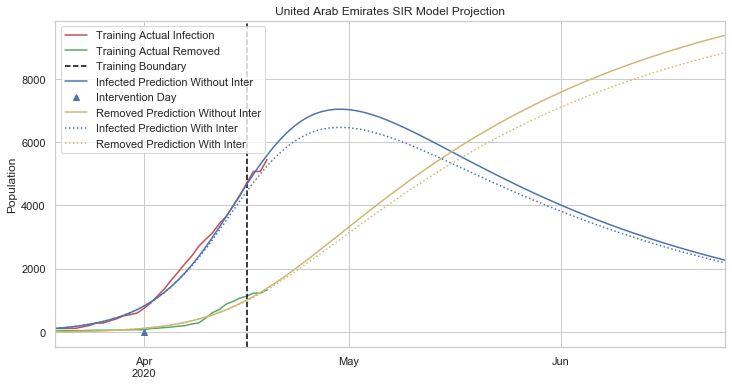

In [21]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-04-01'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-03-15'
obs_end = '2020-06-25'

param, out_df = display_output('United Arab Emirates',intervention_param,obs_start,obs_end,cutoff=100,decay_L=50,decay_k=4) 

### South Korea Projection (WIP)

Estimated Parameter: R0  5.19, | Training Mean Square Log Error: 0.001 
Apex Day Without Intervention: Mar 22 2020 | Maximum Active Infected Population: 5285
Apex Day With Intervention: Mar 22 2020 | Maximum Active Infected Population: 4886
Forecasted Value:  [2232, 2145, 2061, 1980, 1902, 1827, 1755, 1685]


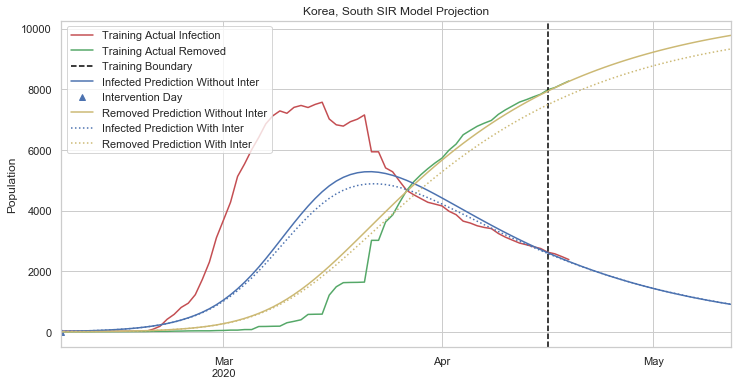

In [22]:
Date_threshold = '2020-04-15' # Cutoff date to validate the results
intervention_param = ['2020-02-07'] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-02-07'
obs_end = '2020-05-12'

param, out_df = display_output('Korea, South',intervention_param,obs_start,obs_end,cutoff=0,decay_L=80,decay_k=5) 

### China Projection

In [ ]:
Date_threshold = '2020-02-07' # Cutoff date to validate the results
intervention_param = [None] # [None, 2.7]# day and the R0 value; None if no intervention
obs_start = '2020-01-23'
obs_end = '2020-05-12'

param, out_df = display_output('China',intervention_param,obs_start,obs_end,cutoff=1,decay_L=80,decay_k=5) 

# Reference 
<br> https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model
<br> https://towardsdatascience.com/social-distancing-to-slow-the-coronavirus-768292f04296
<br> https://neherlab.org/covid19/
<br> https://www.who.int/bulletin/online_first/20-255695.pdf
<br> https://www.researchgate.net/publication/339323999_Epidemic_analysis_of_COVID-19_in_China_by_dynamical_modeling
